<a href="https://colab.research.google.com/github/HNXJ/GSDR/blob/main/GSDR_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSDR implementation and usage in Jaxley


add_ref{brxiv, jxley, github, dynasim}

## Initialization

In [2]:
%pip install jaxley
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import jax
import numpy as np
import jaxley as jx
import jax.numpy as jnp

import matplotlib.pyplot as plt

from jax import jit, vmap, value_and_grad
from jaxley.channels import Leak, HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, sparse_connect, connect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.4/231.4 kB 5.3 MB/s eta 0:00:00


## Basic neuronal circuits

### 1. Neuronal toy problem

### 2. Single neuron model

#### a. Membrane average potential

#### b. Average firing rate

### Neuronal population model

#### Tau(20-I), AFR(80-E) 35-10


#### 80E-20I 20Hz-70Hz

#### 80E-20I Gamma(40-100)/Beta(10-30)

### Resembling spectral dynamics of neural signals recorded in visual cortex

#### E-I-Ig

#### Bench

# Functions

Mechanisms, algorithms and required functions for this notebook.

In [3]:
import jax.numpy as jnp
import jaxley as jx
import numpy as np
import optax
import jax

from typing import Any, Callable, NamedTuple, Optional
from jaxley.channels import Channel, HH
from jaxley.synapses import Synapse
from flax.struct import dataclass


class GradedGABAa(Synapse):
    """
    Graded fast Inhibitory Synapse. (GABAa) - Translated from Matlab (Dynasim)
    Ref: Golowasch et al. (1999) ; Prinz, A. A., et al. (2004).
    """
    def __init__(self, tauD_GABAa: Optional[float] = None):
        super().__init__()
        self.synapse_params = {
            "gGABAa": 0.01,       # Conductance (uS) - MODIFIED TO 0.01
            "EGABAa": -80.0,     # Reversal Potential (mV)
            "tauDGABAa": 10.0,        # Decay (ms)
            "tauRGABAa": 0.5,         # Rise (ms)
            "slopeGABAa": 5.0,        # Steepness of activation
            "V_thGABAa": -20.0        # Threshold (mV) - Tuned to activate during spikes
        }

        if tauD_GABAa is not None:
            self.synapse_params["tauDGABAa"] = tauD_GABAa

        self.synapse_states = {"sGABAa": 0.01}

    def update_states(self, states, dt, pre_v, post_v, params):
        # s' = -s/tauD + 0.5*(1+tanh((V-Vth)/slope)) * ((1-s)/tauR)
        s = states["sGABAa"]
        activation = 0.5 * (1 + jnp.tanh((pre_v - params["V_thGABAa"]) / params["slopeGABAa"]))
        d_s = (-s / params["tauDGABAa"]) + activation * ((1 - s) / params["tauRGABAa"])
        return {"sGABAa": s + d_s * dt}

    def compute_current(self, states, pre_v, post_v, params):
        return params["gGABAa"] * states["sGABAa"] * (post_v - params["EGABAa"])


class GradedGABab(Synapse):
    """
    Graded slow Inhibitory Synapse. (GABAb)
    Ref: Golowasch et al. (1999) ; Prinz, A. A., et al. (2004).
    """
    def __init__(self, tauD_GABAb: Optional[float] = None):
        super().__init__()
        self.synapse_params = {
            "gGABAb": 0.05,       # Conductance (uS)
            "EGABAb": -95.0,     # Reversal Potential (mV)
            "tauDGABAb": 200.0,        # Decay (ms)
            "tauRGABAb": 10.0,         # Rise (ms)
            "slopeGABAb": 5.0,        # Steepness of activation
            "V_thGABAb": -20.0        # Threshold (mV) - Tuned to activate during spikes
        }

        if tauD_GABAb is not None:
            self.synapse_params["tauDGABAb"] = tauD_GABAb

        self.synapse_states = {"sGABAb": 0.001}

    def update_states(self, states, dt, pre_v, post_v, params):
        # s' = -s/tauD + 0.5*(1+tanh((V-Vth)/slope)) * ((1-s)/tauR)
        s = states["sGABAb"]
        activation = 0.5 * (1 + jnp.tanh((pre_v - params["V_thGABAb"]) / params["slopeGABAb"]))
        d_s = (-s / params["tauDGABAb"]) + activation * ((1 - s) / params["tauRGABAb"])
        return {"sGABAb": s + d_s * dt}

    def compute_current(self, states, pre_v, post_v, params):
        return params["gGABAb"] * states["sGABAb"] * (post_v - params["EGABAb"])


class GradedAMPA(Synapse):
    """
    Graded Excitatory Synapse. - Translated from Matlab (Dynasim)
    Same dynamics as GradedGABAa, but with E_rev = 0 mV and faster kinetics.
    """
    def __init__(self, tauD_AMPA: Optional[float] = None):
        super().__init__()
        self.synapse_params = {
            "gAMPA": 0.01,       # Conductance (uS) - MODIFIED TO 0.01
            "EAMPA": 0.0,        # Reversal Potential (mV) - EXCITATORY
            "tauDAMPA": 5.0,         # Faster decay for AMPA
            "tauRAMPA": 0.2,         # Fast rise
            "slopeAMPA": 5.0,
            "V_thAMPA": -20.0        # Threshold (mV)
        }

        if tauD_AMPA is not None:
            self.synapse_params["tauDAMPA"] = tauD_AMPA

        self.synapse_states = {"sAMPA": 0.01}

    def update_states(self, states, dt, pre_v, post_v, params):
        s = states["sAMPA"]
        # Using same naming convention for internal params, mapped to AMPA
        activation = 0.5 * (1 + jnp.tanh((pre_v - params["V_thAMPA"]) / params["slopeAMPA"]))
        d_s = (-s / params["tauDAMPA"]) + activation * ((1 - s) / params["tauRAMPA"])
        return {"sAMPA": s + d_s * dt}

    def compute_current(self, states, pre_v, post_v, params):
        return params["gAMPA"] * states["sAMPA"] * (post_v - params["EAMPA"])


class Inoise(Channel):
    """
    Stochastic Ornstein-Uhlenbeck noise channel. - Translated from Matlab (Dynasim)
    """
    def __init__(self, name: str = None, initial_seed: Optional[int] = None, initial_amp_noise: Optional[float] = None):
        self.current_is_in_mA_per_cm2 = True
        super().__init__(name)

        self.channel_params = {
            "amp_noise": 0.01,  # This acts as Sigma (fluctuation amplitude) [mA/cm^2]
            "mean": 0.0,        # The baseline current drive [mA/cm^2]
            "tau": 10.0,         # Correlation time constant [ms]
        }
        # If no initial_seed is provided, generate a random one using numpy.
        # This ensures each Inoise instance gets a unique starting seed.
        if initial_seed is None:
            self.channel_params["seed"] = float(np.random.randint(0, 2**31 - 1))
        else:
            self.channel_params["seed"] = float(initial_seed)

        if initial_amp_noise is None:
            self.channel_params["amp_noise"] = float(0.005)
        else:
            self.channel_params["amp_noise"] = float(initial_amp_noise)

        self.channel_states = {"n": 0.00, "step": 0.0}
        self.current_name = "i_noise"

    def update_states(self, states, dt, v, params):
        """
        Updates the noise state 'n' using an Ornstein-Uhlenbeck process.
        """
        n = states["n"]
        step = states["step"]

        # 1. RNG Handling
        # When JAXley vmaps the update_states function, params["seed"] will be an array.
        # All other inputs (n, step, v, dt) will also be batched (arrays).
        # We need to vmap the PRNGKey and fold_in calls.

        # Ensure seed is an integer type for PRNGKey
        seeds_int = params["seed"].astype(int)

        # Create base keys (potentially batched)
        if seeds_int.ndim == 0:
            base_key = jax.random.PRNGKey(seeds_int)
        else:
            base_key = jax.vmap(jax.random.PRNGKey)(seeds_int)

        # Fold in step (potentially batched)
        if step.ndim == 0:
            step_key = jax.random.fold_in(base_key, step.astype(int))
        else:
            step_key = jax.vmap(jax.random.fold_in)(base_key, step.astype(int))

        # Generate normal random numbers (potentially batched)
        # A single JAX PRNGKey has shape (2,) and ndim=1.
        # An array of N JAX PRNGKeys has shape (N, 2) and ndim=2.
        if step_key.ndim == 1: # if step_key is a single key
            xi = jax.random.normal(step_key)
        else: # if step_key is an array of keys (ndim 2 for key array)
            xi = jax.vmap(jax.random.normal)(step_key)

        # 2. Physics (Ornstein-Uhlenbeck)
        # dn = -(n - mean)/tau * dt + sigma*sqrt(2/tau)*dW
        mu = params["mean"]
        sigma = params["amp_noise"]
        tau = params["tau"]

        drift = (mu - n) / tau * dt
        diffusion = sigma * jnp.sqrt(2.0 / tau) * xi * jnp.sqrt(dt)

        new_n = n + drift + diffusion

        # Return new state AND increment step
        return {"n": new_n, "step": step + 1.0}

    def compute_current(self, states, v, params):
        """
        Returns the current.
        Note: We return negative 'n' so that a positive mean acts
        as an excitatory (depolarizing) injection in the cable equation.
        """
        return -states["n"]

    def init_state(self, states, v, params, delta_t):
        """
        Initialize to the mean value.
        This needs to handle batched parameters if JAXley vmaps init_state.
        """
        # If params["mean"] is a scalar, jnp.zeros_like(params["mean"]) is a scalar 0.0.
        # If params["mean"] is an array, jnp.zeros_like(params["mean"]) is an array of 0.0s.
        # This handles both cases correctly.
        return {"n": jnp.zeros_like(params["mean"]) + params["mean"], "step": jnp.zeros_like(params["mean"]) + 0.0}


@dataclass
class GSDRState:
    inner_state: Any
    params_opt: Any
    inner_state_opt: Any
    loss_opt: float
    a: float
    a_opt: float

def GSDR(
    inner_optimizer: optax.GradientTransformation,
    delta_distribution: Callable = jax.random.normal,
    deselection_threshold: float = 10.0,
    a_init: float = 0.5,
    a_dynamic: bool = True
) -> optax.GradientTransformation:
    """
    Optax-compliant implementation of the Genetic-Stochastic Delta Rule.
    """

    def init_fn(params):
        inner_state = inner_optimizer.init(params)
        return GSDRState(
            inner_state=inner_state,
            params_opt=params,
            inner_state_opt=inner_state,
            loss_opt=jnp.inf,
            a=a_init,
            a_opt=a_init
        )

    def update_fn(updates, state, params=None, value=None, key=None):
        if params is None:
            raise ValueError("GSDR requires 'params' to be passed to update().")
        if value is None:
            raise ValueError("GSDR requires current loss 'value' to be passed to update().")
        if key is None:
            raise ValueError("GSDR requires a random 'key' to be passed to update().")

        grads = updates
        loss = value

        delta_key, a_key = jax.random.split(key)

        is_new_opt = loss < state.loss_opt

        new_params_opt = jax.tree.map(
            lambda cur, opt: jnp.where(is_new_opt, cur, opt),
            params, state.params_opt
        )
        new_loss_opt = jnp.where(is_new_opt, loss, state.loss_opt)
        new_a_opt = jnp.where(is_new_opt, state.a, state.a_opt)

        new_inner_state_opt = jax.tree.map(
            lambda cur, opt: jnp.where(is_new_opt, cur, opt),
            state.inner_state, state.inner_state_opt
        )

        is_deselect = (loss > (new_loss_opt * deselection_threshold)) & (new_loss_opt != jnp.inf)

        if a_dynamic:
            # Modify a_random to be a perturbation around state.a, then sigmoid
            delta_a = jax.random.uniform(a_key, minval=-0.2, maxval=0.2)
            a_candidate = state.a + delta_a
            a_random = jax.nn.sigmoid(a_candidate) # Ensure it is between 0 and 1
            next_a = jnp.where(is_deselect, new_a_opt, a_random)
        else:
            next_a = state.a # Constant

        next_inner_state = jax.tree.map(
            lambda opt, cur: jnp.where(is_deselect, opt, cur),
            new_inner_state_opt, state.inner_state
        )

        inner_updates, updated_inner_state = inner_optimizer.update(grads, next_inner_state, params)

        param_leaves, treedef = jax.tree_util.tree_flatten(params)
        subkeys = jax.random.split(delta_key, len(param_leaves))
        param_keys_tree = jax.tree_util.tree_unflatten(treedef, subkeys)

        delta_noise = jax.tree.map(
            lambda p, k: delta_distribution(k, p.shape),
            params, param_keys_tree
        )
        delta = jax.tree.map(lambda n, p: n * p, delta_noise, params)

        combined_updates = jax.tree.map(
            lambda d, g: next_a * d + (1 - next_a) * g,
            delta, inner_updates
        )

        reset_updates = jax.tree.map(
            lambda opt, cur: opt - cur,
            new_params_opt, params
        )

        final_updates = jax.tree.map(
            lambda reset, calc: jnp.where(is_deselect, reset, calc),
            reset_updates, combined_updates
        )

        final_inner_state = jax.tree.map(
            lambda reset_st, advanced_st: jnp.where(is_deselect, reset_st, advanced_st),
            new_inner_state_opt, updated_inner_state
        )

        new_state = GSDRState(
            inner_state=final_inner_state,
            params_opt=new_params_opt,
            inner_state_opt=new_inner_state_opt,
            loss_opt=new_loss_opt,
            a=next_a,
            a_opt=new_a_opt
        )

        return final_updates, new_state

    return optax.GradientTransformation(init_fn, update_fn)


class Dataset:
    """A simple Dataloader which returns batches of the data.

    Instead of using this simple dataloader, you can also just use one from
    PyTorch or Tensorflow. You do not have to understand what is going on here
    to follow this tutorial.
    """

    def __init__(self, inputs: np.ndarray, labels: np.ndarray):
        """Initialize the dataloader.

        Args:
            inputs: Array of shape (num_samples, num_dim)
            labels: Array of shape (num_samples,)
        """
        assert len(inputs) == len(labels), "Inputs and labels must have same length"
        self.inputs = inputs
        self.labels = labels
        self.num_samples = len(inputs)
        self._rng_state = None
        self.batch_size = 1

    def shuffle(self, seed=None):
        """Shuffle the dataset in-place"""
        self._rng_state = np.random.get_state()[1][0] if seed is None else seed
        np.random.seed(self._rng_state)
        indices = np.random.permutation(self.num_samples)
        self.inputs = self.inputs[indices]
        self.labels = self.labels[indices]
        return self

    def batch(self, batch_size):
        """Create batches of the data."""
        self.batch_size = batch_size
        return self

    def __iter__(self):
        """Iterate over the dataset."""
        self.shuffle(seed=self._rng_state)
        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            yield self.inputs[start:end], self.labels[start:end]
        self._rng_state += 1


# Workbench


### Q1

In [4]:
import jax.numpy as jnp
import jaxley as jx
import numpy as np


def network_ei_neurons(num_e: int, num_i: int, amp_noise: float):
    """
    Creates a JAXley network with excitatory and inhibitory neurons.

    Args:
        num_e: Number of excitatory neurons.
        num_i: Number of inhibitory neurons.
        amp_noise: Amplitude of the Ornstein-Uhlenbeck noise current.

    Returns:
        A jx.Network object.
    """
    # 1. Create a prototype compartment.
    comp = jx.Compartment()

    # 2. Create a prototype branch. The user specified ncomp=2.
    branch = jx.Branch(comp, ncomp=2)

    # 3. Create a neuron
    neuron = jx.Cell(branch.copy(), parents=[-1, 0, 0])

    # Each cell has an Inoise channel and a Leak channel, so add them to the base compartment.
    noise_channel = Inoise(initial_amp_noise=amp_noise)
    leak_channel = Leak()
    neuron.insert(HH())
    neuron.insert(noise_channel)

    # 3. Create excitatory (e) neurons.
    # Use branch.copy() for each cell to ensure independent states.
    # The parents argument to jx.Cell defines internal branch connectivity.
    e_cells = [neuron for i in range(num_e)]

    # 4. Create inhibitory (i) neurons.
    i_cells = [neuron for i in range(num_i)]

    # 5. Combine all cells into a single list
    all_cells = e_cells + i_cells

    # 6. Create the JAXley network
    net = jx.Network(all_cells)
    net.insert(leak_channel)

    # Get JAXley View objects for the excitatory and inhibitory cell populations
    # This is crucial as jx.connect expects View objects, not raw Python lists.
    e_cell_view = net.cell(list(range(num_e)))
    i_cell_view = net.cell(list(range(num_e, num_e + num_i)))

    # 7. Define synapse models
    ampa_syn = GradedAMPA(tauD_AMPA=10.0)
    gabaa_syn = GradedGABAa(tauD_GABAa=10.0)

    # 8. Connect the neurons using fully_connect as suggested.
    # Note: fully_connect typically assumes loc=0.5 and does not take connection_spacing or name
    # directly in its basic signature based on user's suggestion.

    # E-E connections: Excitatory to Excitatory
    fully_connect(
        e_cell_view.branch(0).loc(0.0),
        e_cell_view.branch(1).loc(0.0),
        ampa_syn
    )

    # E-I connections: Excitatory to Inhibitory
    fully_connect(
        e_cell_view.branch(0).loc(0.0),
        i_cell_view.branch(1).loc(0.0),
        ampa_syn
    )

    # I-E connections: Inhibitory to Excitatory
    fully_connect(
        i_cell_view.branch(0).loc(0.0),
        e_cell_view.branch(1).loc(0.0),
        gabaa_syn
    )

    # I-I connections: Inhibitory to Inhibitory
    fully_connect(
        i_cell_view.branch(0).loc(0.0),
        i_cell_view.branch(1).loc(0.0),
        gabaa_syn
    )

    return net


/usr/local/lib/python3.12/dist-packages/jaxley/modules/base.py:780: UserWarning: This method is experimental, use at your own risk.
  warnings.warn("This method is experimental, use at your own risk.")


Added 150 external_states. See `.externals` for details.
Added 150 recordings. See `.recordings` for details.


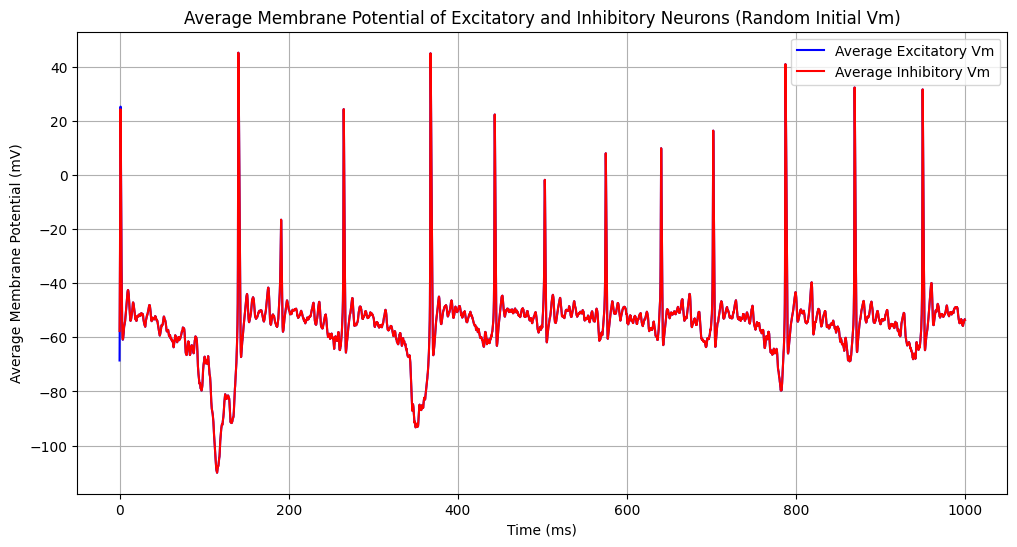

In [6]:
# Make network

num_e = 20
num_i = 5
net = network_ei_neurons(num_e=num_e, num_i=num_i, amp_noise=0.01)

# Set gAMPA and gGABAa explicitly after network creation
net.set('gAMPA', 0.1)
net.set('gGABAa', 0.1)

# Setup simulation parameters
t_max = 1000.0  # ms
dt = 0.1      # ms
# Adjust times to match the number of points returned by jx.integrate (t_max / dt + 1)
times = jnp.linspace(0, t_max, int(t_max / dt) + 1)

# Create a step current pulse
i_stim_amp = 0.01 # nA
stim_start = 500.0 # ms
stim_end = 600.0  # ms

current_pulse = jnp.zeros_like(times)
start_idx = int(stim_start / dt)
end_idx = int(stim_end / dt)
current_pulse = current_pulse.at[start_idx:end_idx].set(i_stim_amp)

# Apply stimulus to all cells/compartments in the network
# JAXley's stimulate method applies to all compartments in the network if a 1D array is given.
net.stimulate(current_pulse)

# Delete previous recordings and set up new recordings
net.delete_recordings()
net.record()

# Determine number of compartments per cell from the network setup
# In network_ei_neurons, branch = jx.Branch(comp, ncomp=2), and parents=[-1,0,0] for Cell means 3 segments (soma + 2 branches)
# If each branch has 2 comps, then 3 segments * 2 comps/segment = 6 compartments per cell.
n_compartments_per_cell = 6 # Corrected from 3 to 6
num_cells_in_net = num_e + num_i # Ensure num_e and num_i are defined correctly from network creation
total_num_compartments = num_cells_in_net * n_compartments_per_cell

# Generate random initial voltages for all compartments
key = jax.random.PRNGKey(42) # For reproducibility
initial_v_min = -80.0
initial_v_max = -50.0
initial_v_random = jax.random.uniform(key, (total_num_compartments,),
                                      minval=initial_v_min, maxval=initial_v_max)

# Set the initial 'v' state on the network before integration
net.set('v', initial_v_random)

# Integrate the network
response_v = jx.integrate(net, t_max=t_max, delta_t=dt)

# Visualize all neurons' potentials
v_data = response_v # Corrected: response_v itself is the voltage data

plt.figure(figsize=(12, 6))

# Calculate average potential for excitatory neurons
e_comp_indices = [i * n_compartments_per_cell + 0 for i in range(num_e)]
if e_comp_indices:
    avg_e_v = jnp.mean(v_data[e_comp_indices, :], axis=0)
    plt.plot(times, avg_e_v, color='blue', label='Average Excitatory Vm')

# Calculate average potential for inhibitory neurons
i_comp_indices = [i * n_compartments_per_cell + 0 for i in range(num_e, num_e + num_i)]
if i_comp_indices:
    avg_i_v = jnp.mean(v_data[i_comp_indices, :], axis=0)
    plt.plot(times, avg_i_v, color='red', label='Average Inhibitory Vm')

plt.title('Average Membrane Potential of Excitatory and Inhibitory Neurons (Random Initial Vm)')
plt.xlabel('Time (ms)')
plt.ylabel('Average Membrane Potential (mV)')
plt.legend()
plt.grid(True)
plt.show()

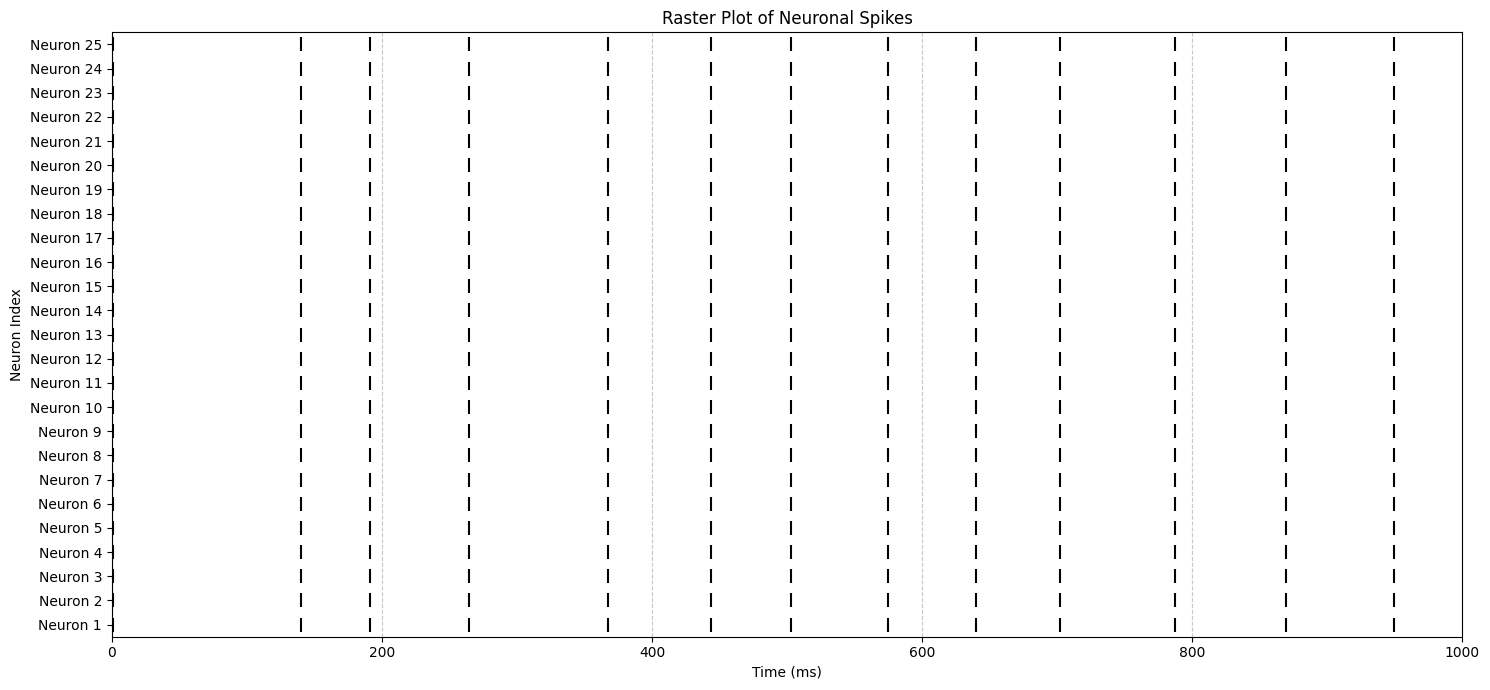

In [9]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

def detect_spikes(voltage_trace, threshold=0.0):
    """
    Detects spikes from a voltage trace based on upward crossing of a threshold.

    Args:
        voltage_trace (jnp.ndarray): 1D array of membrane potential over time.
        threshold (float): The voltage threshold for spike detection.

    Returns:
        jnp.ndarray: Array of spike times (indices).
    """
    # Find indices where voltage crosses the threshold from below
    crossings = (voltage_trace[:-1] < threshold) & (voltage_trace[1:] >= threshold)
    spike_indices = jnp.where(crossings)[0] + 1  # +1 to get the index after crossing
    return spike_indices

# Assuming 'times', 'v_data', 'num_cells_in_net', and 'n_compartments_per_cell' are available from the previous execution

plt.figure(figsize=(15, 7))

spike_threshold = -20.0 # Define a spike threshold (e.g., -10mV for action potentials)

# Collect all spike times for raster plotting
all_spike_times = []
all_neuron_indices = []
num_cells_in_net = num_e + num_i

for i in range(num_cells_in_net):
    # Get the voltage trace for the first compartment of cell i
    global_comp_idx = i * n_compartments_per_cell + 0
    neuron_voltage_trace = v_data[global_comp_idx, :]

    # Detect spikes for this neuron
    spike_indices = detect_spikes(neuron_voltage_trace, threshold=spike_threshold)

    # Convert spike indices to actual time values
    current_neuron_spike_times = times[spike_indices]

    # Append to lists for plotting
    all_spike_times.append(current_neuron_spike_times)
    all_neuron_indices.append(jnp.full_like(current_neuron_spike_times, i))

# Flatten the lists for scatter plot
if all_spike_times:
    flat_spike_times = jnp.concatenate(all_spike_times)
    flat_neuron_indices = jnp.concatenate(all_neuron_indices)

    plt.scatter(flat_spike_times, flat_neuron_indices, marker='|', s=100, color='black')

plt.title('Raster Plot of Neuronal Spikes')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.yticks(range(num_cells_in_net), [f'Neuron {i+1}' for i in range(num_cells_in_net)])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, t_max)
plt.ylim(-0.5, num_cells_in_net - 0.5) # Adjust y-limits for better visualization
plt.tight_layout()
plt.show()

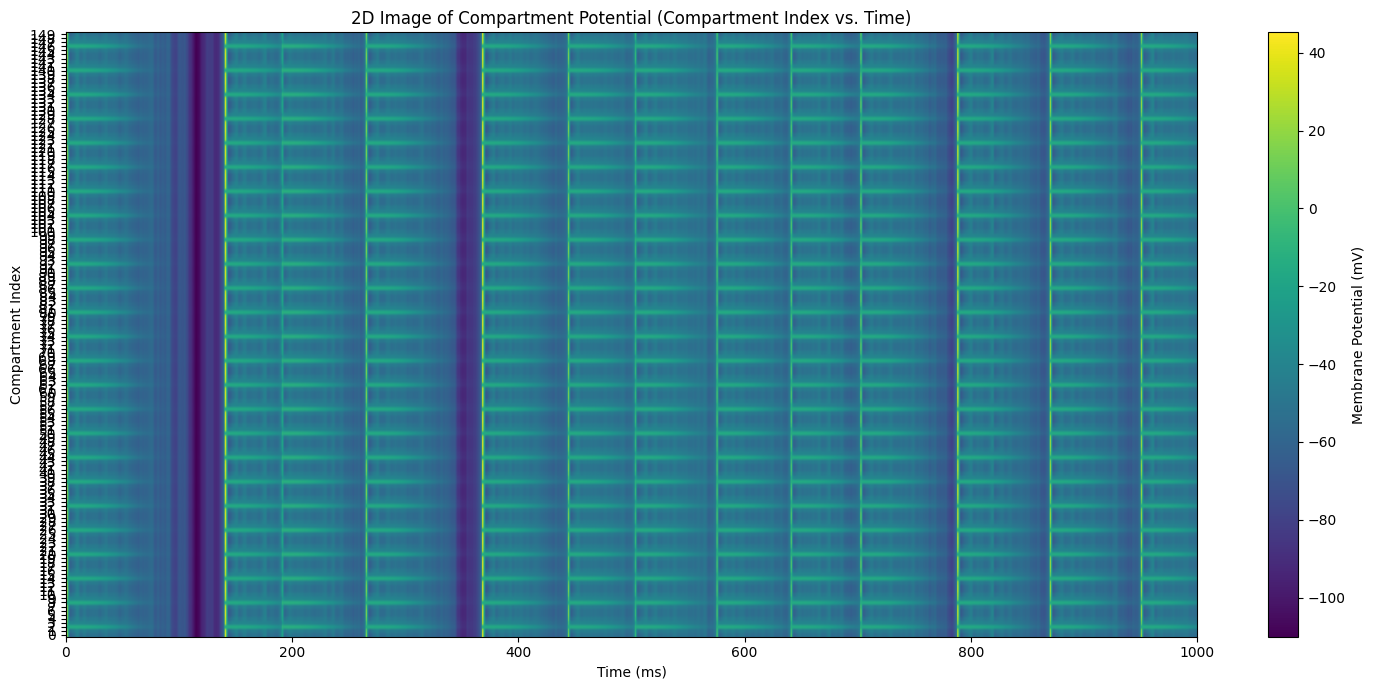

In [10]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Assuming 'v_data', 'times', and 'n_compartments_per_cell' are available from previous execution

plt.figure(figsize=(15, 7))

# Prepare data for the 2D image
# The user asked to plot all rows of v_data directly.
# v_data has shape (total_num_compartments, num_time_steps)
potential_image_data = v_data

num_rows_to_plot = potential_image_data.shape[0] # This will be the total number of compartments

plt.imshow(
    potential_image_data,
    aspect='auto',
    cmap='viridis',
    origin='lower',
    extent=[times.min(), times.max(), -0.5, num_rows_to_plot - 0.5] # Adjust extent for all compartments
)

plt.colorbar(label='Membrane Potential (mV)')
plt.title('2D Image of Compartment Potential (Compartment Index vs. Time)') # Updated title for clarity
plt.xlabel('Time (ms)')
plt.ylabel('Compartment Index') # Updated label for clarity
plt.yticks(range(num_rows_to_plot)) # Adjust yticks for all compartments
plt.tight_layout()
plt.show()

In [11]:
import warnings

# Option 1: Suppress all UserWarning messages
warnings.filterwarnings("ignore", category=UserWarning)

print("UserWarnings are now suppressed.")

# warnings.filterwarnings("default", category=UserWarning)
# print("UserWarnings are now re-enabled.")

UserWarnings are now suppressed.


### Q2

In [12]:
net = network_ei_neurons(num_e=20, num_i=5, amp_noise=0.01)
gAMPA_lower_bounds = 0.00
gAMPA_upper_bounds = 1.00

gGABA_lower_bounds = 0.00
gGABA_upper_bounds = 1.00

import jaxley.optimize.transforms as jt

# Correctly define transform as ParamTransform for the entire parameter tree
transform = jx.ParamTransform([
    {"gAMPA": jt.SigmoidTransform(gAMPA_lower_bounds, gAMPA_upper_bounds)},
    {"gGABAa": jt.SigmoidTransform(gGABA_lower_bounds, gGABA_upper_bounds)}
])
net.make_trainable("gAMPA")
net.make_trainable("gGABAa")

# Perform recordings setup once on the base network object outside the jitted predict function
net.delete_recordings()
net.record()

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Added 150 recordings. See `.recordings` for details.


In [17]:
inputs = jnp.array([0.0, 0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3]) # nA
labels = jnp.array([5.0, 5.0, 11.0, 11.0, 15.0, 15.0, 21.0, 21.0]) # Hz

print("Input stimulation amplitudes (nA):")
print(inputs)
print("Target average spike rates for excitatory neurons (Hz):")
print(labels)

Input stimulation amplitudes (nA):
[0.  0.  0.1 0.1 0.2 0.2 0.3 0.3]
Target average spike rates for excitatory neurons (Hz):
[ 5.  5. 11. 11. 15. 15. 21. 21.]


In [18]:
def calculate_average_firing_rate(voltage_traces, times, num_e, n_compartments_per_cell, spike_threshold=-10.0):
    # Helper function to detect spikes from a voltage trace
    def detect_spikes_single_trace(voltage_trace, threshold):
        crossings = (voltage_trace[:-1] < threshold) & (voltage_trace[1:] >= threshold)
        spike_indices = jnp.where(crossings)[0] + 1
        return spike_indices

    excitatory_spike_counts = []
    for i in range(num_e):
        global_comp_idx = i * n_compartments_per_cell + 0 # Consider the first compartment of each excitatory neuron
        neuron_voltage_trace = voltage_traces[global_comp_idx, :]
        spike_indices = detect_spikes_single_trace(neuron_voltage_trace, threshold=spike_threshold)
        excitatory_spike_counts.append(len(spike_indices))

    # Convert spike counts to firing rate (Hz)
    # Firing rate = (number of spikes / duration in ms) * 1000 ms/s
    duration_ms = times[-1] - times[0]
    # If there are no excitatory neurons, return 0 to avoid division by zero
    if num_e == 0:
        return jnp.array(0.0)

    total_excitatory_spikes = jnp.sum(jnp.array(excitatory_spike_counts))
    average_firing_rate_hz = (total_excitatory_spikes / (num_e * duration_ms)) * 1000.0
    return average_firing_rate_hz


@jax.jit
def predict(params, i_stim_amp, net_total_compartments, net_prototype): # Added net_total_compartments

    t_max = 1000.0  # ms
    dt = 0.1      # ms
    times = jnp.linspace(0, t_max, int(t_max / dt) + 1)

    # Create a step current pulse based on i_stim_amp
    current_pulse = jnp.zeros_like(times)
    stim_start = 500.0 # ms
    stim_end = 600.0  # ms
    start_idx = int(stim_start / dt)
    end_idx = int(stim_end / dt)
    current_pulse = current_pulse.at[start_idx:end_idx].set(i_stim_amp)

    # Apply stimulus only to excitatory neurons.
    num_e = 20 # Assuming num_e is 20 as set in network_ei_neurons
    n_compartments_per_cell = 6 # As determined earlier
    stim_indices = [i * n_compartments_per_cell + 0 for i in range(num_e)]

    # JAXley's stimulate method can take a 2D array (compartment x time) for selective stimulation
    full_current_injection = jnp.zeros((net_total_compartments, len(times))) # Use net_total_compartments
    for idx in stim_indices:
        full_current_injection = full_current_injection.at[idx, :].set(current_pulse)

    # Use data_stimulate for JIT compatibility; it returns a new network instance
    net_with_stim = net_prototype.data_stimulate(full_current_injection)

    # Generate random initial voltages for all compartments for consistency, even in jitted func
    key = jax.random.PRNGKey(jax.random.PRNGKey(0).bits[0] + jnp.array(i_stim_amp*1000, dtype=jnp.int32)) # Unique key per stim_amp
    initial_v_min = -80.0
    initial_v_max = -50.0
    initial_v_random = jax.random.uniform(key, (net_total_compartments,), minval=initial_v_min, maxval=initial_v_max) # Use net_total_compartments

    # Set initial 'v' state using data_set for JIT compatibility; it returns a new network instance
    net_configured = net_with_stim.data_set('v', initial_v_random)

    # Integrate the network, passing the parameters directly to jx.integrate
    response_v = jx.integrate(net_configured, t_max=t_max, delta_t=dt, params=params)

    # Calculate average firing rate of excitatory neurons
    avg_e_firing_rate = calculate_average_firing_rate(response_v, times, num_e, n_compartments_per_cell)

    return avg_e_firing_rate

print("Jitted 'predict' function created and 'calculate_average_firing_rate' helper defined.")

Jitted 'predict' function created and 'calculate_average_firing_rate' helper defined.


In [27]:
from jax import value_and_grad
from functools import partial

def _loss_fn_impl(params, inputs, labels, net_total_compartments, net_instance):
    # Create a partially applied predict function where net_total_compartments and net_instance are fixed.
    # The resulting 'partially_applied_predict' now implicitly has a signature of (params, i_stim_amp).
    partially_applied_predict = partial(predict,
                                        net_total_compartments=net_total_compartments,
                                        net_prototype=net_instance)

    # Now, vmap this partially applied function over the 'inputs' (i_stim_amp).
    # The in_axes only needs to cover the remaining arguments of 'partially_applied_predict'.
    vmap_predict = jax.vmap(partially_applied_predict, in_axes=(None, 0))

    # Call vmap_predict with only params and inputs (i_stim_amp).
    predictions = vmap_predict(params, inputs)
    # Compute Mean Squared Error
    loss = jnp.mean((predictions - labels)**2)
    return loss

# Create a jitted version of the loss function explicitly.
# Mark only net_total_compartments (index 3) as static, net_instance (index 4) should be dynamic
# (We keep static_argnums=(3,) here because 'loss_fn' itself is jitted, not its internal vmap call)
loss_fn = jax.jit(_loss_fn_impl, static_argnums=(3,))

# Create a jitted version of the loss function that also computes gradients
# loss_grad_fn now expects net_total_compartments and net_instance as additional arguments.
loss_grad_fn = value_and_grad(loss_fn, argnums=0)

print("Jitted 'loss_fn' and 'loss_grad_fn' created.")

Jitted 'loss_fn' and 'loss_grad_fn' created.


In [28]:
initial_params = net.get_parameters() # Get initial trainable parameters from the network

# Initialize the inner optimizer (e.g., Adam)
inner_optimizer = optax.adam(learning_rate=0.01) # Learning rate can be tuned

# Initialize the GSDR optimizer
gsdr_optimizer = GSDR(inner_optimizer=inner_optimizer, a_init=0.5, a_dynamic=True)

# Initialize the optimizer state
opt_state = gsdr_optimizer.init(initial_params)
opt_params = transform.inverse(initial_params)

print("GSDR optimizer and initial state created.")

GSDR optimizer and initial state created.


In [29]:
jitted_grad = jit(value_and_grad(loss_fn, argnums=0))

dataloader = Dataset(inputs, labels)
dataloader = dataloader.shuffle(seed=0).batch(2)

key = jax.random.PRNGKey(0) # This key is for the training loop's random operations
print("Starting training...")

for epoch in range(10):

    key, step_key = jax.random.split(key)
    epoch_loss = 0.0

    for batch_ind, batch in enumerate(dataloader):
        current_batch, label_batch = batch
        # Pass net.total_compartments and net to the jitted_grad function
        loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch, net.total_compartments, net)

        # Get current parameters in the original space for GSDR
        current_network_params = transform.forward(opt_params)

        updates, opt_state = gsdr_optimizer.update(gradient, opt_state,
            params=current_network_params,   # Required for GSDR
            value=loss_val,      # Required for GSDR
            key=step_key)      # Required for GSDR (using the training loop's step_key)
        opt_params = optax.apply_updates(opt_params, updates)
        epoch_loss += loss_val

    print(f"epoch {epoch}, loss {epoch_loss}, alpha {opt_state.a}")

final_params = transform.forward(opt_params)

Starting training...


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (None, 10001).

# end